# Calculate Tandem Stop Codons Overepresentation

This notebook takes as input the file `GenomeInfo.xlsx`. It uses the `genCode` and the `utrFile` columns to find the genetic code and the the location of the file with the UTRs for the organisms.

Files generated, all in the `Results` folder:

1. `Results_UTRlength.tsv`: This gives the regular calculation using the expected frequency for stop codons based on the frequency of stops in all frames.

2. `OrgStats_UTRlength.tsv`: This gives some stats about the UTRs of all organisms.

3. `TandemFirst_All_UTRlength.tsv`: Gives the number of genes with tandem stop codons in all the positions analyzed. 

## Read organism information

This just reads the `GenomeInfo.xlsx` file and convert it into a data frame.

In [1]:
UTRlen = 20

import os
import pandas as pd
info = pd.read_excel('GenomeInfo.xlsx')
for number, organism in info.iterrows():
    if (not os.path.exists("utrs/"+organism['UTR File']+'.utr'+str(UTRlen))):
        print(organism['Organism'],': Missing UTR File')


## Calculate tandem stop overrepresentation

The first cell determines how many nucleotide positions after the real stop should be analyzed, given by the the integer division of the UTR length by 3.

This will determine the name of the output files, which will be `Results_UTRlength.tsv` and `OrgStats_UTRlength.tsv`, where UTR length is the number of nucleotides analyzed. The files are:

1. `Results_UTRlength.tsv`: This gives the regular calculation using the expected frequency for stop codons based on the frequency of stops in all frames.

2. `OrgStats_UTRlength.tsv`: This gives some stats about the UTRs of all organisms.


In [46]:
import math

numberOfPositions = UTRlen // 3

file = 'Results/ORgStats_'+str(UTRlen)+'.tsv'
fileout = open(file,'w')

print("""Organism, NumberOfUTRs, ObservedTSC, ExpectedTSC""")

fileout.write("""Organism\tCode\tNumberOfUTRs\tNumberOfUTRsWithTSC\tExpected\tA\tC\tG\tT\n""")

probTandem = {}  

countTandem = {}    # counts how many tandem stops were found in each position per org
foundTandemNo = {}    # counts how many utrs have in frame tandem stops per org
foundTandem = {}    # fraction of utrs with in frame tandem stops per org
scoreTandem = {}    # SCO per position for eah organism
foundTandemOrg = {} # Fraction of UTRs with TSCs in the organism

for number, organism in info.iterrows():
    filein = open("utrs/"+organism['UTR File']+'.utr'+str(UTRlen))
    genCode = organism['GeneticCode']
    taxon = organism['Grouping']
    org = organism['Organism']
    countTandem[org] = [0] * numberOfPositions
    scoreTandem[org] = [0] * numberOfPositions
    foundTandemNo[org] = 0 # counts how many utrs have tandem in this org
    
    if genCode == 1:
        stops = ['TAA','TAG','TGA']
    elif genCode == 6:
        stops = ['TGA']
    elif genCode == 10:
        stops = ['TAA','TAG']
    else:
        print("Problem with genetic code for ", org)

    #Calculate frequency of stops in the 3' UTRs
    filein.readline()

    allUTRs = 0      #counts how many utrs were analyzed for each org
    A = 0
    T = 0
    G = 0
    C = 0

    inframe = 0
    inframepos = 0
    for line in filein:
        num, org2, realStop, utr, startCodon = line.split()
        utr = utr.upper()
        
        if len(utr) < UTRlen:
            next

        A += utr.count('A')
        C += utr.count('C')
        G += utr.count('G')
        T += utr.count('T')

        allUTRs += 1    
        for i in range(numberOfPositions):
            if utr[i*3:i*3+3] in stops:
                countTandem[org][i] += 1 # per position
                foundTandemNo[org] += 1    # total number of utrs with tandem stops in the current org
                break

    filein.close()
    
    # Observed frequency of tandem stops in frame:
    foundTandem[org] = foundTandemNo[org]/allUTRs  # fraction of UTRs with tandem stops
    for i in range(numberOfPositions):
        countTandem[org][i] = countTandem[org][i]/allUTRs # fraction of utrs with tandem in each position

    # Type 1: Use ATCG composition for expected frequency
    tot = A+C+G+T
    comp = {}
    comp['A'] = A/tot
    comp['C'] = C/tot
    comp['G'] = G/tot
    comp['T'] = T/tot

    stopProb = 0    #probability of finding a stop in a position of the utr based on composition
    for stop in stops:
        probCurrent = comp[stop[0]]*comp[stop[1]]*comp[stop[2]]
        stopProb += probCurrent

    probTandem[org] = stopProb

    fileout.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(
        org, genCode, allUTRs, foundTandemNo[org],stopProb*allUTRs, comp['A'],
        comp['C'], comp['G'], comp['T']))

    # Calculate expected tandems per position
    for i in range(numberOfPositions):
        score = countTandem[org][i]/(stopProb * (1-stopProb)**i)

        if score <= 0:
            scoreTandem[org][i] = float('nan')
        else:
            scoreTandem[org][i] = math.log(score)


    #print(scoreTandem1[org])
    scoreTandem[org].insert(0, taxon)

    tandemProb = 0
    for i in range(numberOfPositions):
        tandemProb += (stopProb * (1-stopProb)**i)

    tandemExp = allUTRs * tandemProb
        
    foundTandemOrg[org] = [taxon, allUTRs, foundTandemNo[org], 
                           tandemExp, stopProb]

    print(org, allUTRs, foundTandemNo[org], 
          tandemExp)

fileout.close()

Organism, NumberOfUTRs, ObservedTSC, ExpectedTSC
Stentor coeruleus 34247 18582 16414.247521827467
Euplotes octocarinatus 28836 10028 10713.557646896756
Ichthyophthirius mutifilis 6852 628 566.9926435296034
Oxytricha trifallax 24776 3849 2573.763471669735
Paramecium tetraurelia  39248 4912 3262.2956313442883
Pseudocohnilembus persalinus 13176 1752 1013.5399420248332
Stylonychia lemnae 15741 2629 1646.686209557388
Tetrahymena borealis 20342 2900 1982.3340499085648
Tetrahymena ellioti 20223 2470 1704.792703807936
Tetrahymena malaccensis 21694 2626 1863.5819013490316
Tetrahymena thermophila 26498 3046 2259.497423306154
Giardia intestinalis 6498 1779 1800.0026292618913
Giardia muris 4650 1126 1216.1552592018538
Spironucleus salmonicida 8079 798 841.4919681651514
Babesia sp. 3064 994 1009.2725704890354
Cryptosporidium muris 3904 1774 1799.4559048996973
Cryptosporidium parvum 3150 1258 1348.7387972717368
Neospora caninum 6883 911 1608.5796898749597
Plasmodium falciparum 5321 2012 2763.1942081

In [47]:
cols = ['Type']
for i in range(numberOfPositions):
    cols.append(i+1)

results1 = pd.DataFrame(scoreTandem).transpose()
results1.columns = cols
results1.index.name = 'Organism'

results2 = pd.DataFrame(foundTandemOrg).transpose()
results2.columns = ['Taxon','#UTR', 'Observed', 'Expected', 'ProbabilityOfStop']
results2.index.name = 'Organism'

In [48]:
results1.head()

,Type,1,2,3,4,5,6
Organism,,,,,,,
Stentor coeruleus,Ciliate (Standard Code),0.179679,0.0828378,0.219979,0.10722,0.032176,0.0652293
Euplotes octocarinatus,"Ciliate (Stop = UAG, UAA)",-0.211248,-0.056406,-0.0319971,-0.0111493,-0.0218287,-0.0395969
Ichthyophthirius mutifilis,Ciliate (Stop = UGA),0.3502,0.0550948,0.117346,0.0936421,-0.0493545,-0.0236593
Oxytricha trifallax,Ciliate (Stop = UGA),0.258172,0.454174,0.479633,0.510707,0.353422,0.335709
Paramecium tetraurelia,Ciliate (Stop = UGA),0.669694,0.597889,0.453902,0.338473,0.133748,0.0906653


In [49]:
results2.head()

,Taxon,#UTR,Observed,Expected,ProbabilityOfStop
Organism,,,,,
Stentor coeruleus,Ciliate (Standard Code),34247,18582,16414.2,0.103055
Euplotes octocarinatus,"Ciliate (Stop = UAG, UAA)",28836,10028,10713.6,0.0744918
Ichthyophthirius mutifilis,Ciliate (Stop = UGA),6852,628,566.993,0.0142925
Oxytricha trifallax,Ciliate (Stop = UGA),24776,3849,2573.76,0.0181143
Paramecium tetraurelia,Ciliate (Stop = UGA),39248,4912,3262.3,0.014359


In [50]:
file = 'Results/Results_'+str(UTRlen)+'.tsv'
results1.to_csv(file,sep='\t')
file = 'Results/TandemAllPos'+str(UTRlen)+'.tsv'
results2.to_csv(file, sep='\t')

## Statistics

### Excess in each of the first positions

In [51]:
from scipy.stats import mannwhitneyu

tests = ['Ciliate (Stop = UGA)',
         'Other Alveolates (Standard Code)',
         'Other Eukaryotes (Standard Code)']

stats1 = []
for i in range(1,7):
    # Test ciliate vs alveolate
    ciliate = list(results1[results1['Type'] == tests[0]][i])
    alveolate = list(results1[results1['Type'] == tests[1]][i])
    eukaryote = list(results1[results1['Type'] == tests[2]][i])
    other = alveolate + eukaryote
    
    stat, p1 = mannwhitneyu(ciliate, alveolate)
    stat, p2 = mannwhitneyu(ciliate, eukaryote)
    stat, p3 = mannwhitneyu(ciliate, other)
    stat, p4 = mannwhitneyu(alveolate, eukaryote)
    
    stats1.append([i,p1,p2,p3,p4])
    
positionSig1 = pd.DataFrame(stats1, columns = ['Position',
                                             'Ciliates X Alveolates',
                                             'Ciliates X Eukaryotes',
                                             'Ciliates X All',
                                             'Alveolates X Eukaryotes'])
positionSig1.to_csv('Results/StatsPosition_Type1_'+str(UTRlen)+'.tsv',sep='\t')
positionSig1

,Position,Ciliates X Alveolates,Ciliates X Eukaryotes,Ciliates X All,Alveolates X Eukaryotes
0,1,0.000166,1.455002e-06,1.231168e-06,0.172490
1,2,0.000095,1.455002e-06,1.061864e-06,0.490959
2,3,0.000072,7.862535e-07,5.824917e-07,0.139991
3,4,0.000095,8.593051e-07,6.777234e-07,0.250667
4,5,0.000284,2.237728e-06,2.052155e-06,0.139991
5,6,0.000126,1.222240e-06,9.858312e-07,0.227247


### Collapse tetrahymena

In [52]:
#change the Tetrahymena values in excel on Results_20.tsv to a single value based on the average
results1tet = pd.read_csv('Results/Results_20_Tet.txt',sep='\t')
#results1tet.head(9)

In [53]:
tests = ['Ciliate (Stop = UGA)',
         'Other Alveolates (Standard Code)',
         'Other Eukaryotes (Standard Code)']

stats1 = []
for i in range(1,7):
    # Test ciliate vs alveolate
    ciliate = list(results1tet[results1tet['Type'] == tests[0]][str(i)])
    alveolate = list(results1tet[results1tet['Type'] == tests[1]][str(i)])
    eukaryote = list(results1tet[results1tet['Type'] == tests[2]][str(i)])
    other = alveolate + eukaryote
    
    stat, p1 = mannwhitneyu(ciliate, alveolate)
    stat, p2 = mannwhitneyu(ciliate, eukaryote)
    stat, p3 = mannwhitneyu(ciliate, other)
    stat, p4 = mannwhitneyu(alveolate, eukaryote)
    
    stats1.append([i,p1,p2,p3,p4])
    
positionSig1 = pd.DataFrame(stats1, columns = ['Position',
                                             'Ciliates X Alveolates',
                                             'Ciliates X Eukaryotes',
                                             'Ciliates X All',
                                             'Alveolates X Eukaryotes'])
positionSig1.to_csv('Results/StatsPosition_Type1_Tet'+str(UTRlen)+'.tsv',sep='\t')
positionSig1

,Position,Ciliates X Alveolates,Ciliates X Eukaryotes,Ciliates X All,Alveolates X Eukaryotes
0,1,0.000616,0.000041,0.000037,0.172490
1,2,0.000616,0.000045,0.000040,0.490959
2,3,0.000442,0.000031,0.000027,0.139991
3,4,0.000616,0.000034,0.000031,0.250667
4,5,0.002141,0.000093,0.000099,0.139991
5,6,0.000852,0.000045,0.000043,0.227247


### Excess in all positions

In [54]:
results2.head()

,Taxon,#UTR,Observed,Expected,ProbabilityOfStop
Organism,,,,,
Stentor coeruleus,Ciliate (Standard Code),34247,18582,16414.2,0.103055
Euplotes octocarinatus,"Ciliate (Stop = UAG, UAA)",28836,10028,10713.6,0.0744918
Ichthyophthirius mutifilis,Ciliate (Stop = UGA),6852,628,566.993,0.0142925
Oxytricha trifallax,Ciliate (Stop = UGA),24776,3849,2573.76,0.0181143
Paramecium tetraurelia,Ciliate (Stop = UGA),39248,4912,3262.3,0.014359


In [60]:
from scipy.stats import chisquare as chi2

resultsTemp = []

for index, row in results2.iterrows():
    tot = row['#UTR']
    obs = row['Observed']
    exp = row['Expected']
    org = index
    taxon = row["Taxon"]

    resultsTemp.append([org,taxon,math.log(obs/exp), obs/tot*100, exp/tot*100])
        
results3 = pd.DataFrame(resultsTemp, columns=['org','taxon','CombinedSCO','Observed','Expected'])
results3.head()

,org,taxon,CombinedSCO,Observed,Expected
0,Stentor coeruleus,Ciliate (Standard Code),0.124044,54.258767,47.929008
1,Euplotes octocarinatus,"Ciliate (Stop = UAG, UAA)",-0.066129,34.775974,37.153411
2,Ichthyophthirius mutifilis,Ciliate (Stop = UGA),0.102194,9.165207,8.274849
3,Oxytricha trifallax,Ciliate (Stop = UGA),0.402444,15.535195,10.388132
4,Paramecium tetraurelia,Ciliate (Stop = UGA),0.409250,12.515287,8.312005


## Figure 2

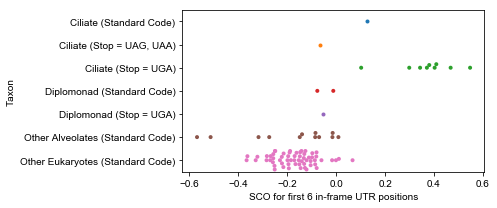

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(1, 1, 1)

sns.swarmplot(x="CombinedSCO", y="taxon", data=results3,
              size=4, linewidth=0)

plt.xlabel('SCO for first 6 in-frame UTR positions')
plt.ylabel('Taxon')

plt.tight_layout()

from PIL import Image
from io import BytesIO

png1 = BytesIO()
fig.savefig(png1, format='png', dpi=300)
png2 = Image.open(png1)
png2.save('Results/Figure2.tiff')

### Figure 3

In [68]:
results3['taxon1'] = 'obs_' + results3['taxon'].astype(str)
results3['taxon2'] = 'exp_' + results3['taxon'].astype(str)

test1 = pd.DataFrame()
test1 = results3[['taxon1','Observed','taxon']]
test1 = test1.rename(columns={"taxon1": "taxonoe", "Observed": "values"})
test2 = pd.DataFrame()
test2 = results3[['taxon2','Expected','taxon']]
test2 = test2.rename(columns={"taxon2": "taxonoe", "Expected": "values"})

test = test2.append(test1)
test.groupby('taxonoe').mean()

,values
taxonoe,
exp_Ciliate (Standard Code),47.929008
"exp_Ciliate (Stop = UAG, UAA)",37.153411
exp_Ciliate (Stop = UGA),8.935643
exp_Diplomonad (Standard Code),26.927374
exp_Diplomonad (Stop = UGA),10.415794
exp_Other Alveolates (Standard Code),32.678540
exp_Other Eukaryotes (Standard Code),29.797010
obs_Ciliate (Standard Code),54.258767
"obs_Ciliate (Stop = UAG, UAA)",34.775974


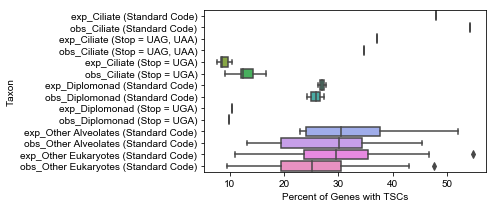

In [76]:
plt.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(1, 1, 1)

sns.boxplot(x="values", y="taxonoe", data=test, 
                         order= ['exp_Ciliate (Standard Code)',
                      'obs_Ciliate (Standard Code)',
                      'exp_Ciliate (Stop = UAG, UAA)',
                      'obs_Ciliate (Stop = UAG, UAA)',
                     'exp_Ciliate (Stop = UGA)',
                     'obs_Ciliate (Stop = UGA)',
                      'exp_Diplomonad (Standard Code)',
                      'obs_Diplomonad (Standard Code)',
                      'exp_Diplomonad (Stop = UGA)',
                      'obs_Diplomonad (Stop = UGA)',
                      'exp_Other Alveolates (Standard Code)',
                      'obs_Other Alveolates (Standard Code)',
                      'exp_Other Eukaryotes (Standard Code)',
                      'obs_Other Eukaryotes (Standard Code)'])
 

plt.xlabel('Percent of Genes with TSCs')
plt.ylabel('Taxon')

plt.tight_layout()

from PIL import Image
from io import BytesIO

png1 = BytesIO()
fig.savefig(png1, format='png', dpi=300)
png2 = Image.open(png1)
png2.save('Results/Figure3.tiff')


### Table 2

In [72]:
results3.head()

,org,taxon,CombinedSCO,Observed,Expected,taxon1,taxon2
0,Stentor coeruleus,Ciliate (Standard Code),0.124044,54.258767,47.929008,obs_Ciliate (Standard Code),exp_Ciliate (Standard Code)
1,Euplotes octocarinatus,"Ciliate (Stop = UAG, UAA)",-0.066129,34.775974,37.153411,"obs_Ciliate (Stop = UAG, UAA)","exp_Ciliate (Stop = UAG, UAA)"
2,Ichthyophthirius mutifilis,Ciliate (Stop = UGA),0.102194,9.165207,8.274849,obs_Ciliate (Stop = UGA),exp_Ciliate (Stop = UGA)
3,Oxytricha trifallax,Ciliate (Stop = UGA),0.402444,15.535195,10.388132,obs_Ciliate (Stop = UGA),exp_Ciliate (Stop = UGA)
4,Paramecium tetraurelia,Ciliate (Stop = UGA),0.409250,12.515287,8.312005,obs_Ciliate (Stop = UGA),exp_Ciliate (Stop = UGA)


In [74]:
results4 = pd.DataFrame()
results4['Average Total SCO'] = results3.groupby('taxon').mean()['CombinedSCO']
results4['Standard Error'] = results3.groupby('taxon').std()['CombinedSCO']
results4['Average % of genes with TSC'] = results3.groupby('taxon').mean()['Observed']
results4['Std '] = results3.groupby('taxon').std()['Observed']
results4['Average Expected % of genes with TSC'] = results3.groupby('taxon').mean()['Expected']
results4['Std Expected SCO'] = results3.groupby('taxon').std()['Expected']

results4.to_csv('Results/Table3.tsv',sep='\t')
results4

,Average Total SCO,Standard Error,Average % of genes with TSC,Std,Average Expected % of genes with TSC,Std Expected SCO
taxon,,,,,,
Ciliate (Standard Code),0.124044,NaN,54.258767,NaN,47.929008,NaN
"Ciliate (Stop = UAG, UAA)",-0.066129,NaN,34.775974,NaN,37.153411,NaN
Ciliate (Stop = UGA),0.369099,0.123107,13.031575,2.247525,8.935643,1.000330
Diplomonad (Standard Code),-0.044380,0.046164,25.796354,2.236297,26.927374,1.093891
Diplomonad (Stop = UGA),-0.053068,NaN,9.877460,NaN,10.415794,NaN
Other Alveolates (Standard Code),-0.185071,0.193627,28.004005,10.453493,32.678540,9.914056
Other Eukaryotes (Standard Code),-0.170373,0.088844,25.251690,7.945347,29.797010,8.792597
